# Librerias

In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from math import pi
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from mpl_toolkits.axes_grid1 import make_axes_locatable
import plotly.graph_objects as go
import matplotlib as mpl
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors

# Archivos

In [125]:
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)

In [126]:
!wget https://raw.githubusercontent.com/bitazaratustra/proyecto_ar/master/data/consumo.csv
!wget https://raw.githubusercontent.com/bitazaratustra/proyecto_ar/master/data/cultivo.csv
!wget https://raw.githubusercontent.com/bitazaratustra/proyecto_ar/master/data/mercado.csv
!wget https://raw.githubusercontent.com/bitazaratustra/proyecto_ar/master/data/trafico.csv
!wget https://raw.githubusercontent.com/bitazaratustra/proyecto_ar/master/data/produccion.csv
!wget https://raw.githubusercontent.com/bitazaratustra/proyecto_ar/master/data/df.csv

--2025-03-02 18:52:48--  https://raw.githubusercontent.com/bitazaratustra/proyecto_ar/master/data/consumo.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4114 (4.0K) [text/plain]
Saving to: ‘consumo.csv.1’

consumo.csv.1       100%[===================>]   4.02K  --.-KB/s    in 0s      

2025-03-02 18:52:48 (62.8 MB/s) - ‘consumo.csv.1’ saved [4114/4114]

--2025-03-02 18:52:48--  https://raw.githubusercontent.com/bitazaratustra/proyecto_ar/master/data/cultivo.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211 [text/plain]


# Constantes

In [127]:
produccion = {
    # Rendimientos por hectárea (toneladas/ha/año)
    "RENDIMIENTO_HOJAS_COLOMBIA": (4.6, 6.4),
    "RENDIMIENTO_HOJAS_PERU": (2.5, 4.0),
    "RENDIMIENTO_HOJAS_BOLIVIA": (1.5, 3.0),

    "CANTIDAD_COSECHAS_COLOMBIA": (4,6),
    "CANTIDAD_COSECHAS_PERU": (3,5),
    "CANTIDAD_COSECHAS_BOLIVIA": (3,3),

    # Coeficientes de conversión
    "HOJAS_A_PASTA_BASE": (300, 400),           # kg hojas por kg pasta base
    "PASTA_BASE_A_CLORHIDRATO": (2.5, 3.0),     # kg pasta base por kg clorhidrato

    # Producción potencial 2022 (toneladas hoja)
    "PRODUCCION_POTENCIAL_COLOMBIA_2022": 8_000_000,
    "PRODUCCION_POTENCIAL_PERU_2022": 2_000_000,
    "PRODUCCION_POTENCIAL_BOLIVIA_2022": 90_000,

    # Rendimiento de opio (kg/ha)
    "RENDIMIENTO_OPIO_AFGANISTAN": 32,
    "RENDIMIENTO_OPIO_MYANMAR": 14,
    "RENDIMIENTO_OPIO_LAOS": 6.5,
    "RENDIMIENTO_OPIO_MEXICO": 20.5,
    "RENDIMIENTO_OPIO_COLOMBIA": (20, 40),

    # Conversión a heroína
    "OPIO_A_MORFINA": 10,        # kg opio → 1 kg morfina
    "MORFINA_A_HEROINA": 0.9,    # kg morfina → 0.9 kg heroína

    # Producción México (DEA)
    "PRODUCCION_HEROINA_MEXICO_ANUAL": 90,  # toneladas

    # Laboratorios detectados (2022)
    "LABORATORIOS_EEUU_2022": 133,
    "LABORATORIOS_MEXICO_2022": 25,
    "LABORATORIOS_CHEQUIA_2022": 199,

    # Producción México (DEA)
    "PORCENTAJE_METANFETAMINAS_EEUU_MEXICO": 0.98,  # 98% del mercado
}

precios = {
    # Cocaína
    "PRECIO_COLOMBIA": 1_215.06,
    "PRECIO_PERU": 2_800.00,
    "PRECIO_BOLIVIA": 2_400.00,
    "PRECIO_ESPAÑA": 13_240.00,
    "PRECIO_EEUU": 35_500.00,

    # Heroína
    "PRECIO_PAKISTAN": 2_586.05,
    "PRECIO_INDIA": 191_331.41,
    "PRECIO_ESTADOS_UNIDOS_HEROINA": 35_500.00,

    # Metanfetaminas
    "PRECIO_MEXICO": 4_815.00,
    "PRECIO_EEUU_METANFETAMINA": 10_500.00,

    # Cannabis
    "PRECIO_RUSIA": 28_789.46,
    "PRECIO_MADAGASCAR": 18.12,
}

consumo = {
    # Prevalencia global (2022)
    "CONSUMIDORES_GLOBALES_COCAINA": 23_000_000,
    "PRODUCCION_GLOBAL_COCAINA_PURA_2022": 2_757,  # toneladas

    # Pureza promedio
    "PUREZA_COCAINA_CALLE": 0.60,  # 60% promedio global

    # Consumo per cápita ajustado
    "CONSUMO_POR_CONSUMIDOR_ANUAL": 82.98,  # gramos/año (cocaína pura) --> (("PRODUCCION_GLOBAL_COCAINA_PURA_2022"*1000)/"CONSUMIDORES_GLOBALES_COCAINA")* ("PUREZA_COCAINA_CALLE")
}

otros_datos = {
    # Costos de prohibición (miles de millones USD)
    "COSTO_PROHIBICION_EEUU": 341_400,
    "COSTO_PROHIBICION_UE": 139_400,
    "COSTO_PROHIBICION_MEXICO": 34_500,

    # Lavado de dinero
    "PORCENTAJE_LAVADO_PIB": (0.02, 0.05),  # 2%-5% del PIB global
}

# Cultivo

In [128]:

data = {
    'País': ['Bolivia', 'Colombia', 'Peru', 'Afganistan', 'Myanmar','Laos', 'Mexico'],
    'Coca': [26000, 119794.83, 58499.21, None, None, None, None],
    'Opio': [None, 408.76, None, 187414.29, 43223.08, 4443.38, 20000]
}

df_cultivo = pd.DataFrame(data)

In [129]:
df_cultivo.head()

,País,Coca,Opio
0,Bolivia,26000.00,NaN
1,Colombia,119794.83,408.76
2,Peru,58499.21,NaN
3,Afganistán,NaN,187414.29
4,Myanmar,NaN,43223.08


<Figure size 1000x600 with 0 Axes>

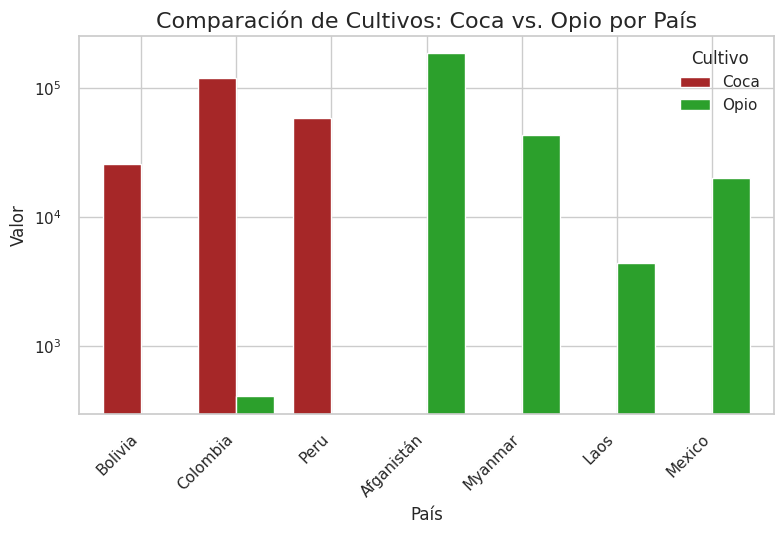

In [130]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))


df_cultivo.set_index('País')[['Coca', 'Opio']].plot(kind='bar', width=0.8, logy=True, color=['#a62728', '#2ca02c'])

plt.title('Comparación de Cultivos: Coca vs. Opio por País', fontsize=16)
plt.xlabel('País', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cultivo', labels=['Coca', 'Opio'])

plt.tight_layout()

In [131]:
total_coca = df_cultivo['Coca'].sum()
total_opio = df_cultivo['Opio'].sum()


df_cultivo_total = pd.DataFrame({'Cultivo': ['Coca', 'Opio'], 'Valor': [total_coca, total_opio]})
df_cultivo_total

,Cultivo,Valor
0,Coca,204294.04
1,Opio,255489.51


In [132]:
def calcular_produccion(df, params):
    resultados = []
    total_coca = 0
    total_opio = 0

    for _, row in df.iterrows():
        pais = row['País']
        reporte = {'País': pais}

        if pd.notnull(row['Coca']):
            if pais == 'Colombia':
                rmin = params["RENDIMIENTO_HOJAS_COLOMBIA"][0]
                rmax = params["RENDIMIENTO_HOJAS_COLOMBIA"][1]
                rmin = rmin * params["CANTIDAD_COSECHAS_COLOMBIA"][0]
                rmax = rmax * params["CANTIDAD_COSECHAS_COLOMBIA"][1]
                hmin = row['Coca'] * rmin
                hmax = row['Coca'] * rmax
                pmin = hmin / params['HOJAS_A_PASTA_BASE'][1]
                pmax = hmax / params['HOJAS_A_PASTA_BASE'][0]
                cmin = pmin / params['PASTA_BASE_A_CLORHIDRATO'][1]
                cmax = pmax / params['PASTA_BASE_A_CLORHIDRATO'][0]
                cmax = pmax / params['PASTA_BASE_A_CLORHIDRATO'][0]
                reporte['Cocaína (Tn)'] = f"{cmin:,.0f} - {cmax:,.0f}"
                total_coca += (cmin + cmax) / 2

            elif pais == 'Peru':
                rmin = params["RENDIMIENTO_HOJAS_PERU"][0]
                rmax = params["RENDIMIENTO_HOJAS_PERU"][1]
                rmin = rmin * params["CANTIDAD_COSECHAS_PERU"][0]
                rmax = rmax * params["CANTIDAD_COSECHAS_PERU"][1]
                hmin = row['Coca'] * rmin
                hmax = row['Coca'] * rmax
                pmin = hmin / params['HOJAS_A_PASTA_BASE'][1]
                pmax = hmax / params['HOJAS_A_PASTA_BASE'][0]
                cmin = pmin / params['PASTA_BASE_A_CLORHIDRATO'][1]
                cmax = pmax / params['PASTA_BASE_A_CLORHIDRATO'][0]
                reporte['Cocaína (Tn)'] = f"{cmin:,.0f} - {cmax:,.0f}"
                total_coca += (cmin + cmax) / 2

            elif pais == 'Bolivia':
                rmin = params["RENDIMIENTO_HOJAS_BOLIVIA"][0]
                rmax = params["RENDIMIENTO_HOJAS_BOLIVIA"][1]
                rmin = rmin * params["CANTIDAD_COSECHAS_BOLIVIA"][0]
                rmax = rmax * params["CANTIDAD_COSECHAS_BOLIVIA"][1]
                hmin = row['Coca'] * rmin
                hmax = row['Coca'] * rmax
                pmin = hmin / params['HOJAS_A_PASTA_BASE'][1]
                pmax = hmax / params['HOJAS_A_PASTA_BASE'][0]
                cmin = pmin / params['PASTA_BASE_A_CLORHIDRATO'][1]
                cmax = pmax / params['PASTA_BASE_A_CLORHIDRATO'][0]
                reporte['Cocaína (Tn)'] = f"{cmin:,.0f} - {cmax:,.0f}"
                total_coca += (cmin + cmax) / 2

        if pd.notnull(row['Opio']):
            if pais == 'Afganistán':
                op = row['Opio'] * params['RENDIMIENTO_OPIO_AFGANISTAN']
                mf = op / params['OPIO_A_MORFINA']
                hr = mf * params['MORFINA_A_HEROINA']
                reporte['Heroína (kg)'] = f"{hr:,.0f}"
                total_opio += hr

            elif pais == 'Myanmar':
                op = row['Opio'] * params['RENDIMIENTO_OPIO_MYANMAR']
                mf = op / params['OPIO_A_MORFINA']
                hr = mf * params['MORFINA_A_HEROINA']
                reporte['Heroína (kg)'] = f"{hr:,.0f}"
                total_opio += hr

            elif pais == 'Laos':
                op = row['Opio'] * params['RENDIMIENTO_OPIO_LAOS']
                mf = op / params['OPIO_A_MORFINA']
                hr = mf * params['MORFINA_A_HEROINA']
                reporte['Heroína (kg)'] = f"{hr:,.0f}"
                total_opio += hr

            elif pais == 'Mexico':
                op = row['Opio'] * params['RENDIMIENTO_OPIO_MEXICO']
                mf = op / params['OPIO_A_MORFINA']
                hr = mf * params['MORFINA_A_HEROINA']
                reporte['Heroína (kg)'] = f"{hr:,.0f}"
                total_opio += hr

            elif pais == 'Colombia':
                op = row['Opio'] * (params['RENDIMIENTO_OPIO_COLOMBIA'][0] + params['RENDIMIENTO_OPIO_COLOMBIA'][1]) / 2
                mf = op / params['OPIO_A_MORFINA']
                hr = mf * params['MORFINA_A_HEROINA']
                reporte['Heroína (kg)'] = f"{hr:,.0f}"
                total_opio += hr

        resultados.append(reporte)

    total_coca_toneladas = total_coca
    total_opio_toneladas = total_opio / 1000

    df_resultados = pd.DataFrame(resultados)
    df_totales = pd.DataFrame({
        'Total Cocaína (toneladas)': [total_coca_toneladas],
        'Total Opio (toneladas)': [total_opio_toneladas]
    })

    return df_resultados, df_totales

df_produccion_final_pais, df_produccion_final_total = calcular_produccion(df_cultivo, produccion)

In [133]:
print("Producción estimada por País:")
df_produccion_final_pais

Producción estimada por País:


,País,Cocaína (Tn),Heroína (kg)
0,Bolivia,32 - 104,NaN
1,Colombia,"459 - 1,022","1,104"
2,Peru,122 - 312,NaN
3,Afganistán,NaN,"539,753"
4,Myanmar,NaN,"54,461"
5,Laos,NaN,"2,599"
6,Mexico,NaN,"36,900"


In [134]:
df_produccion_final_total = df_produccion_final_total.round(2)
print("Producción estimada total:")
df_produccion_final_total

Producción estimada total:


,Total Cocaína (toneladas),Total Opio (toneladas)
0,1025.92,634.82


<ipython-input-135-5a700926562d>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-135-5a700926562d>:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




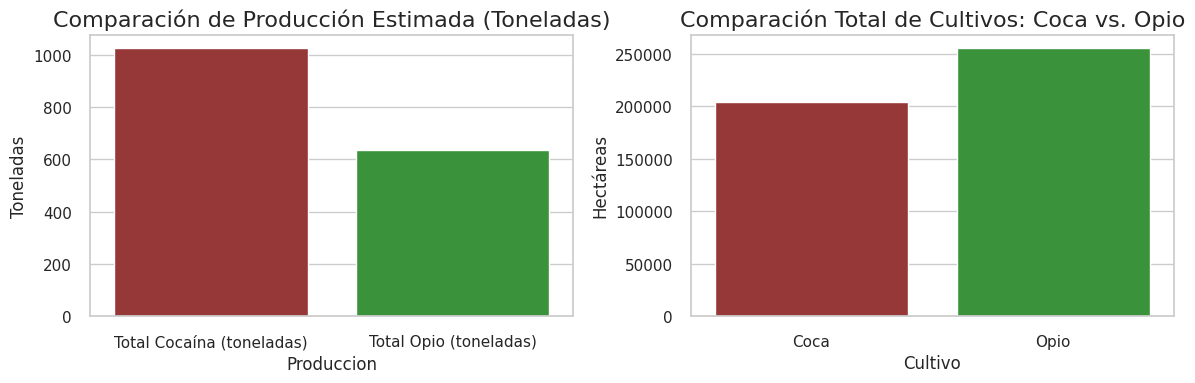

In [135]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(x='Produccion', y='Valor', data=df_produccion_final_total.melt(var_name='Produccion', value_name='Valor'), palette=['#a62728', '#2ca02c'], ax=axes[0])
axes[0].set_title('Comparación de Producción Estimada (Toneladas)', fontsize=16)
axes[0].set_xlabel('Produccion', fontsize=12)
axes[0].set_ylabel('Toneladas', fontsize=12)

sns.barplot(x='Cultivo', y='Valor', data=df_cultivo_total, palette=['#a62728', '#2ca02c'], ax=axes[1])
axes[1].set_title('Comparación Total de Cultivos: Coca vs. Opio', fontsize=16)
axes[1].set_xlabel('Cultivo', fontsize=12)
axes[1].set_ylabel('Hectáreas', fontsize=12)

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Produccion

In [136]:
df_produccion = pd.read_csv('produccion.csv')

In [137]:
df_produccion.head()

,País,Cocaína,Categoría_Cocaína,Opioides,Categoría_Opioides,Metanfetaminas,Categoría_Metanfetaminas
0,Alemania,1.0,MUY BAJA,1.0,MUY BAJA,38.0,ALTA
1,Argentina,287.0,ALTA,1.0,MUY BAJA,4.0,BAJA
2,Australia,10.0,BAJA,6.0,BAJA,308.0,ALTA
3,Austria,NaN,NaN,NaN,NaN,23.0,MEDIA
4,Belgica,22.0,MEDIA,2.0,MUY BAJA,NaN,NaN


In [138]:
df_produccion['Total'] = df_produccion[['Cocaína', 'Metanfetaminas', 'Opioides']].sum(axis=1, skipna=True)

df_produccion.describe()

,Cocaína,Opioides,Metanfetaminas,Total
count,26.000000,19.000000,37.000000,56.000000
mean,1199.153846,10.105263,148.432432,658.250000
std,4818.560704,9.774654,487.680994,3312.423668
min,1.000000,1.000000,1.000000,1.000000
25%,1.000000,2.500000,2.000000,2.750000
50%,12.000000,8.000000,8.000000,15.000000
75%,67.500000,14.000000,32.000000,51.750000
max,24514.000000,40.000000,2806.000000,24520.000000


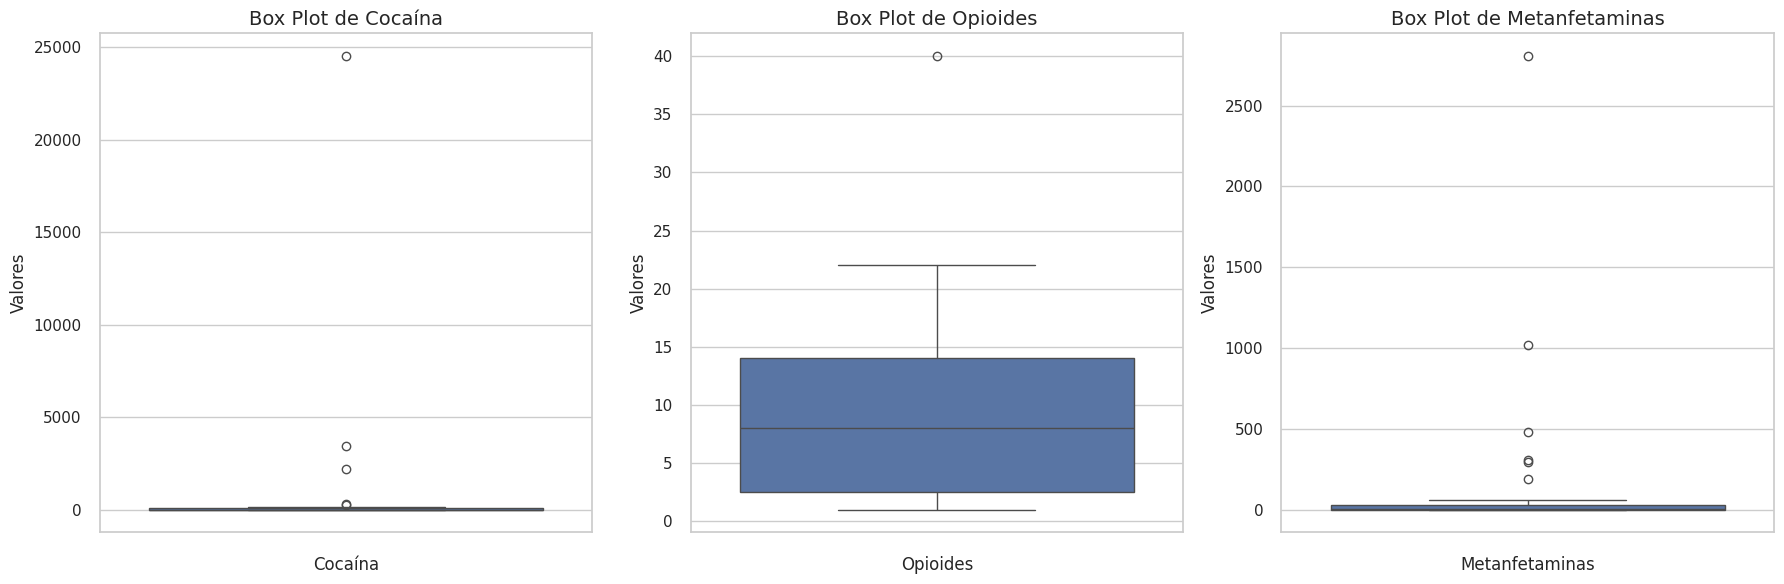

In [139]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.boxplot(data=df_produccion['Cocaína'], ax=axes[0])
axes[0].set_title('Box Plot de Cocaína', fontsize=14)
axes[0].set_xlabel('Cocaína', fontsize=12)
axes[0].set_ylabel('Valores', fontsize=12)

sns.boxplot(data=df_produccion['Opioides'], ax=axes[1])
axes[1].set_title('Box Plot de Opioides', fontsize=14)
axes[1].set_xlabel('Opioides', fontsize=12)
axes[1].set_ylabel('Valores', fontsize=12)

sns.boxplot(data=df_produccion['Metanfetaminas'], ax=axes[2])
axes[2].set_title('Box Plot de Metanfetaminas', fontsize=14)
axes[2].set_xlabel('Metanfetaminas', fontsize=12)
axes[2].set_ylabel('Valores', fontsize=12)

plt.tight_layout()
plt.show()

<ipython-input-140-5284daa05869>:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-140-5284daa05869>:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-140-5284daa05869>:18: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




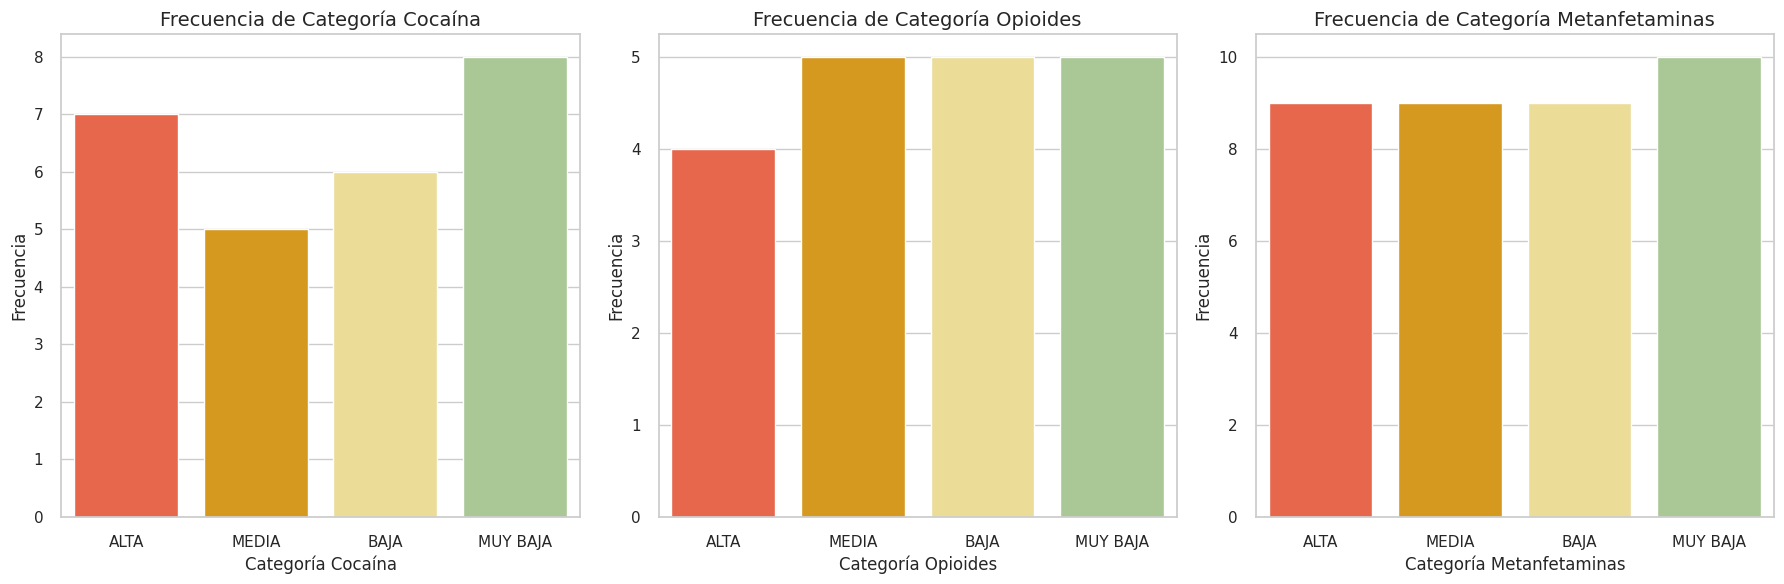

In [140]:
palette = {'MUY BAJA': '#A8D08D', 'BAJA':  '#F9E68A', 'MEDIA': '#F4A300', 'ALTA': '#FF5733'}


df_categories = df_produccion[['Categoría_Cocaína', 'Categoría_Opioides', 'Categoría_Metanfetaminas']]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.countplot(x='Categoría_Cocaína', data=df_categories, ax=axes[0], palette=palette, order=['ALTA', 'MEDIA', 'BAJA', 'MUY BAJA'])
axes[0].set_title('Frecuencia de Categoría Cocaína', fontsize=14)
axes[0].set_xlabel('Categoría Cocaína', fontsize=12)
axes[0].set_ylabel('Frecuencia', fontsize=12)

sns.countplot(x='Categoría_Opioides', data=df_categories, ax=axes[1], palette=palette, order=['ALTA', 'MEDIA', 'BAJA', 'MUY BAJA'])
axes[1].set_title('Frecuencia de Categoría Opioides', fontsize=14)
axes[1].set_xlabel('Categoría Opioides', fontsize=12)
axes[1].set_ylabel('Frecuencia', fontsize=12)

sns.countplot(x='Categoría_Metanfetaminas', data=df_categories, ax=axes[2], palette=palette, order=['ALTA', 'MEDIA', 'BAJA', 'MUY BAJA'])
axes[2].set_title('Frecuencia de Categoría Metanfetaminas', fontsize=14)
axes[2].set_xlabel('Categoría Metanfetaminas', fontsize=12)
axes[2].set_ylabel('Frecuencia', fontsize=12)

plt.tight_layout()
plt.show()

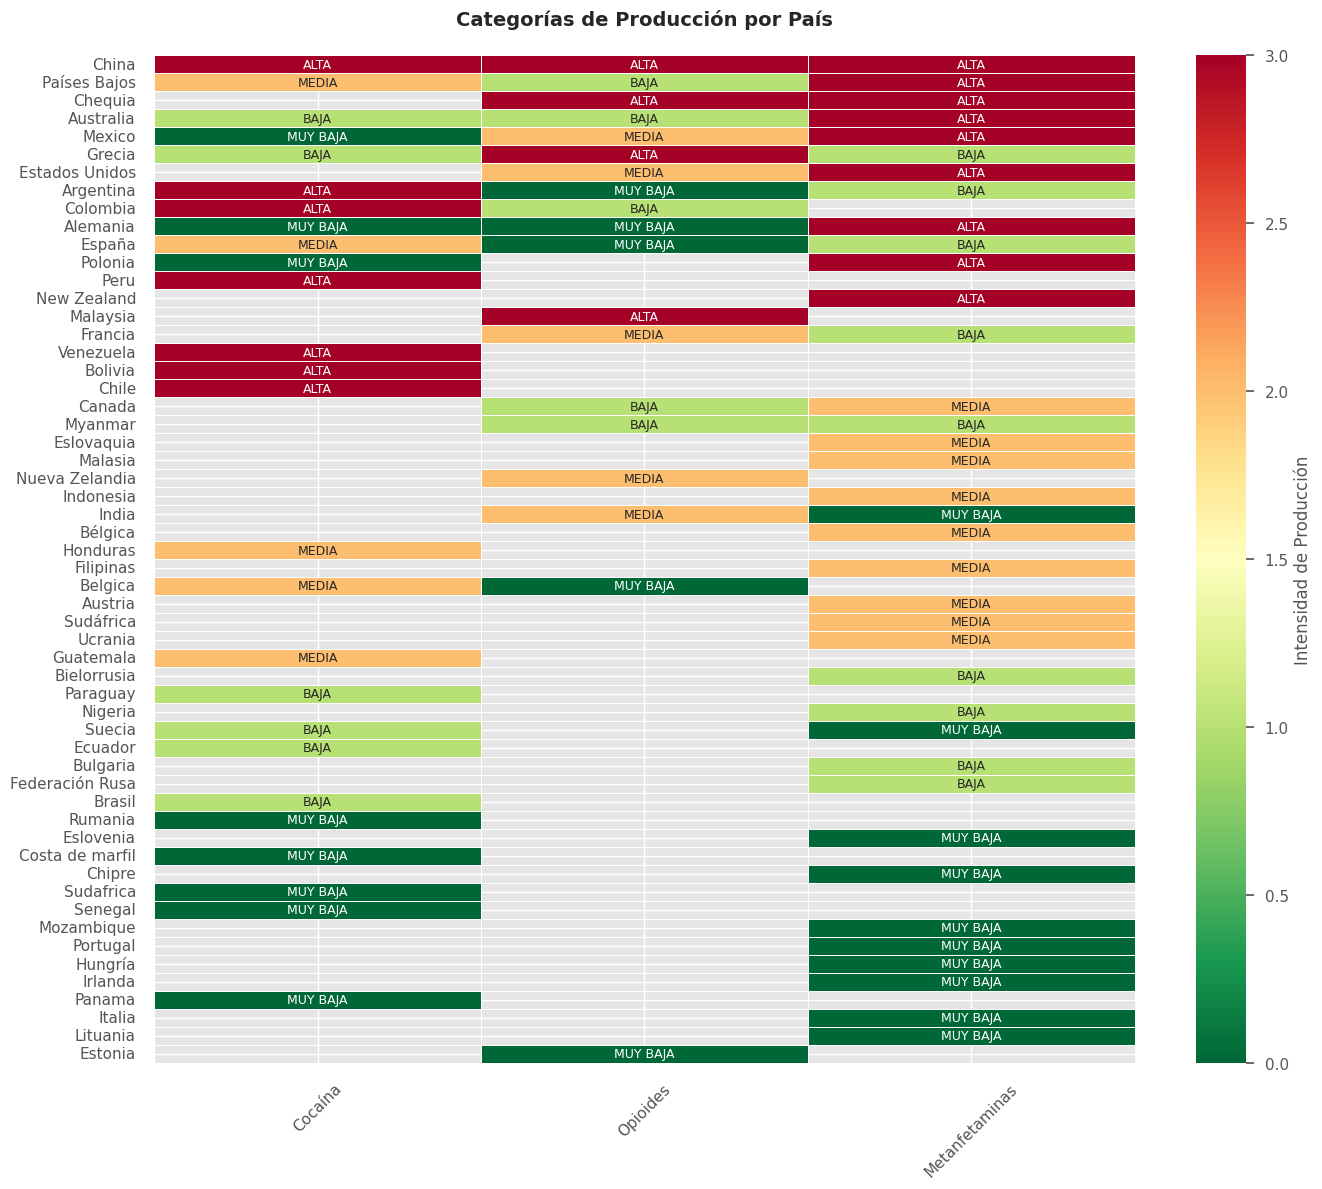

In [141]:
plt.style.use('ggplot')
sns.set_palette("husl")
plt.rcParams['font.family'] = 'DejaVu Sans'

def plot_heatmap():
    categorias = df_produccion[['País', 'Categoría_Cocaína', 'Categoría_Opioides', 'Categoría_Metanfetaminas']].dropna(how='all')

    order = categorias.fillna('Z').apply(lambda x: x.map({'ALTA':3, 'MEDIA':2, 'BAJA':1, 'MUY BAJA':0})).sum(axis=1).sort_values(ascending=False).index
    categorias = categorias.iloc[order]

    heatmap_data = categorias[['Categoría_Cocaína', 'Categoría_Opioides', 'Categoría_Metanfetaminas']]\
        .apply(lambda x: x.map({'ALTA':3, 'MEDIA':2, 'BAJA':1, 'MUY BAJA':0, np.nan: np.nan}))

    plt.figure(figsize=(14, 12))
    ax = sns.heatmap(heatmap_data,
                    annot=categorias[['Categoría_Cocaína', 'Categoría_Opioides', 'Categoría_Metanfetaminas']],
                    cmap='RdYlGn_r',
                    linewidths=0.5,
                    cbar_kws={'label': 'Intensidad de Producción'},
                    annot_kws={'fontsize':9},
                    fmt='')

    ax.set_yticklabels(categorias['País'], rotation=0)
    ax.set_xticklabels(['Cocaína', 'Opioides', 'Metanfetaminas'], rotation=45)
    plt.title('Categorías de Producción por País\n', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_heatmap()

In [142]:
df_produccion[['País', 'Cocaína']].sort_values(by='Cocaína', ascending=False).head()

,País,Cocaína
15,Colombia,24514.0
6,Bolivia,3446.0
46,Peru,2202.0
1,Argentina,287.0
55,Venezuela,271.0


In [143]:
df_produccion[['País', 'Metanfetaminas']].sort_values(by='Metanfetaminas', ascending=False).head()

,País,Metanfetaminas
21,Estados Unidos,2806.0
11,Chequia,1021.0
13,China,479.0
2,Australia,308.0
40,New Zealand,297.0


In [144]:
df_produccion[['País', 'Opioides']].sort_values(by='Opioides', ascending=False).head()

,País,Opioides
36,Malaysia,40.0
26,Grecia,22.0
11,Chequia,19.0
13,China,19.0
37,Mexico,14.0


# Consumo

In [145]:
df_consumo = pd.read_csv('consumo.csv')

In [146]:
df_consumo['Total'] = df_consumo[['Cocaína', 'Cannabis', 'Metanfetaminas', 'Opioides']].sum(axis=1, skipna=True)

In [147]:
df_consumo['Categoría_Total'] = pd.cut(df_consumo['Total'],
                                       bins=[-float('inf'), 3.7, 5.6, 9.45, float('inf')],
                                       labels=['Muy Baja', 'Baja', 'Media', 'Alta'])

In [148]:
df_consumo.head()

,País,Cocaína,Categoría_Cocaína,Cannabis,Categoría_Cannabis,Metanfetaminas,Categoría_Metanfetaminas,Opioides,Categoría_Opioides,Total,Categoría_Total
0,Albania,2.50,Alta,5.60,Media,0.10,Muy Baja,NaN,NaN,8.20,Media
1,Alemania,1.03,Media,6.62,Media,1.15,Alta,0.36,Baja,9.16,Media
2,Argelia,0.01,Muy baja,0.52,Muy baja,0.03,Muy Baja,NaN,NaN,0.56,Muy Baja
3,Argentina,1.20,Media,5.67,Media,NaN,NaN,0.19,Muy baja,7.06,Media
4,Australia,2.73,Alta,10.80,Alta,1.73,Alta,3.10,Alta,18.36,Alta


In [149]:
df_consumo.describe()

,Cocaína,Cannabis,Metanfetaminas,Opioides,Total
count,83.000000,82.000000,63.000000,50.000000,83.000000
mean,0.797108,5.016220,0.683651,0.980600,6.862530
std,0.702470,4.009119,0.854824,1.245528,4.996125
min,0.010000,0.140000,0.020000,0.020000,0.310000
25%,0.250000,2.287500,0.190000,0.255000,3.465000
50%,0.600000,3.915000,0.490000,0.515000,5.240000
75%,1.120000,6.792500,0.875000,1.000000,9.440000
max,2.730000,20.500000,6.100000,5.150000,27.850000


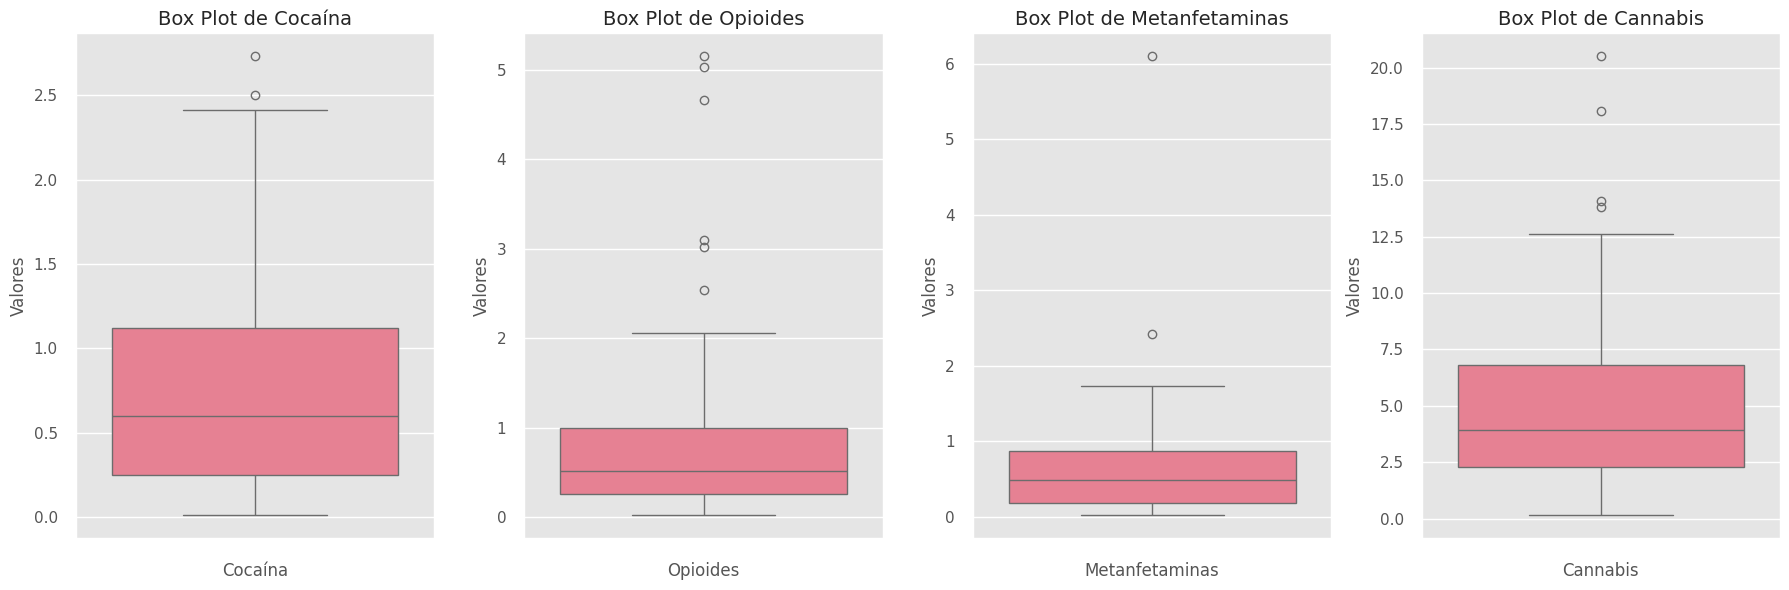

In [150]:
fig, axes = plt.subplots(1, 4, figsize=(18, 6))

sns.boxplot(data=df_consumo['Cocaína'], ax=axes[0])
axes[0].set_title('Box Plot de Cocaína', fontsize=14)
axes[0].set_xlabel('Cocaína', fontsize=12)
axes[0].set_ylabel('Valores', fontsize=12)

sns.boxplot(data=df_consumo['Opioides'], ax=axes[1])
axes[1].set_title('Box Plot de Opioides', fontsize=14)
axes[1].set_xlabel('Opioides', fontsize=12)
axes[1].set_ylabel('Valores', fontsize=12)

sns.boxplot(data=df_consumo['Metanfetaminas'], ax=axes[2])
axes[2].set_title('Box Plot de Metanfetaminas', fontsize=14)
axes[2].set_xlabel('Metanfetaminas', fontsize=12)
axes[2].set_ylabel('Valores', fontsize=12)

sns.boxplot(data=df_consumo['Cannabis'], ax=axes[3])
axes[3].set_title('Box Plot de Cannabis', fontsize=14)
axes[3].set_xlabel('Cannabis', fontsize=12)
axes[3].set_ylabel('Valores', fontsize=12)


plt.tight_layout()
plt.show()

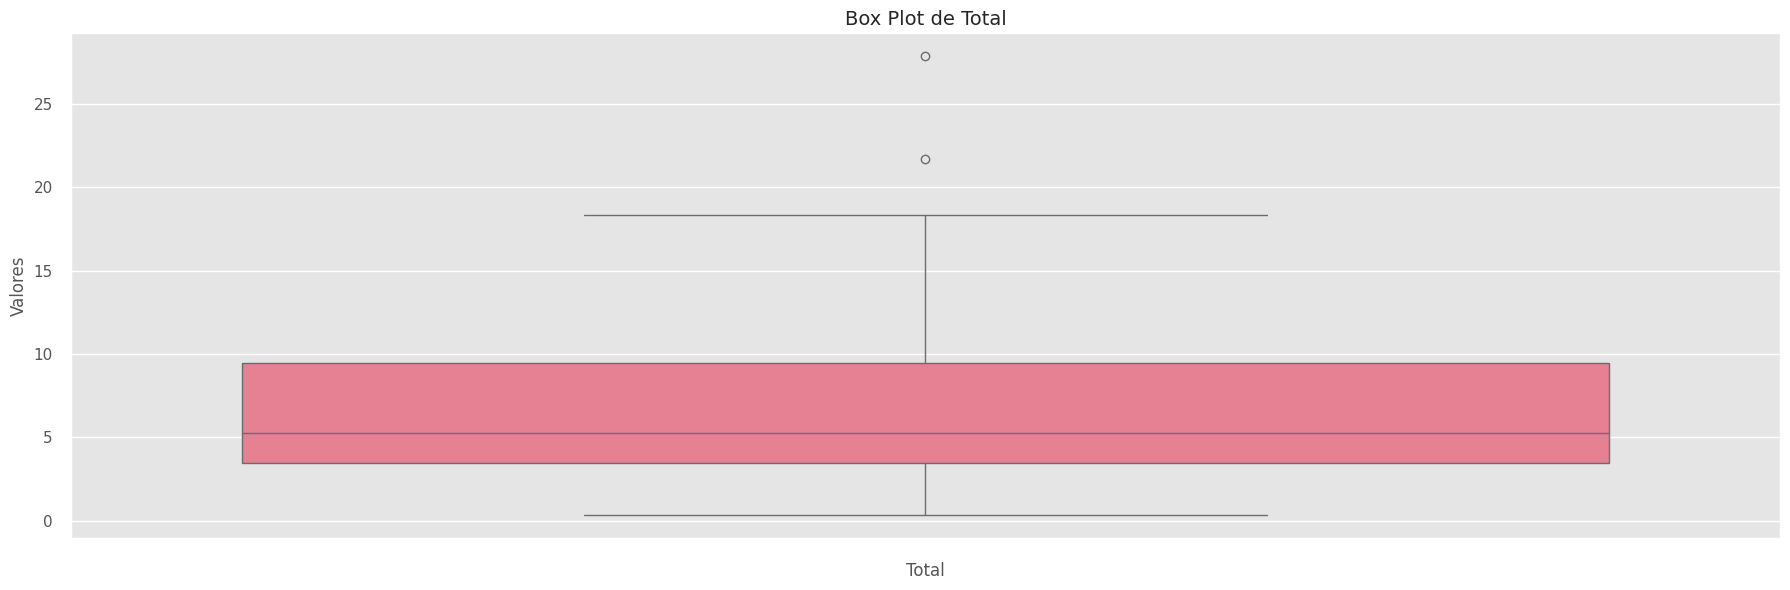

In [151]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.boxplot(data=df_consumo['Total'], ax=ax)
ax.set_title('Box Plot de Total', fontsize=14)
ax.set_xlabel('Total', fontsize=12)
ax.set_ylabel('Valores', fontsize=12)

plt.tight_layout()
plt.show()

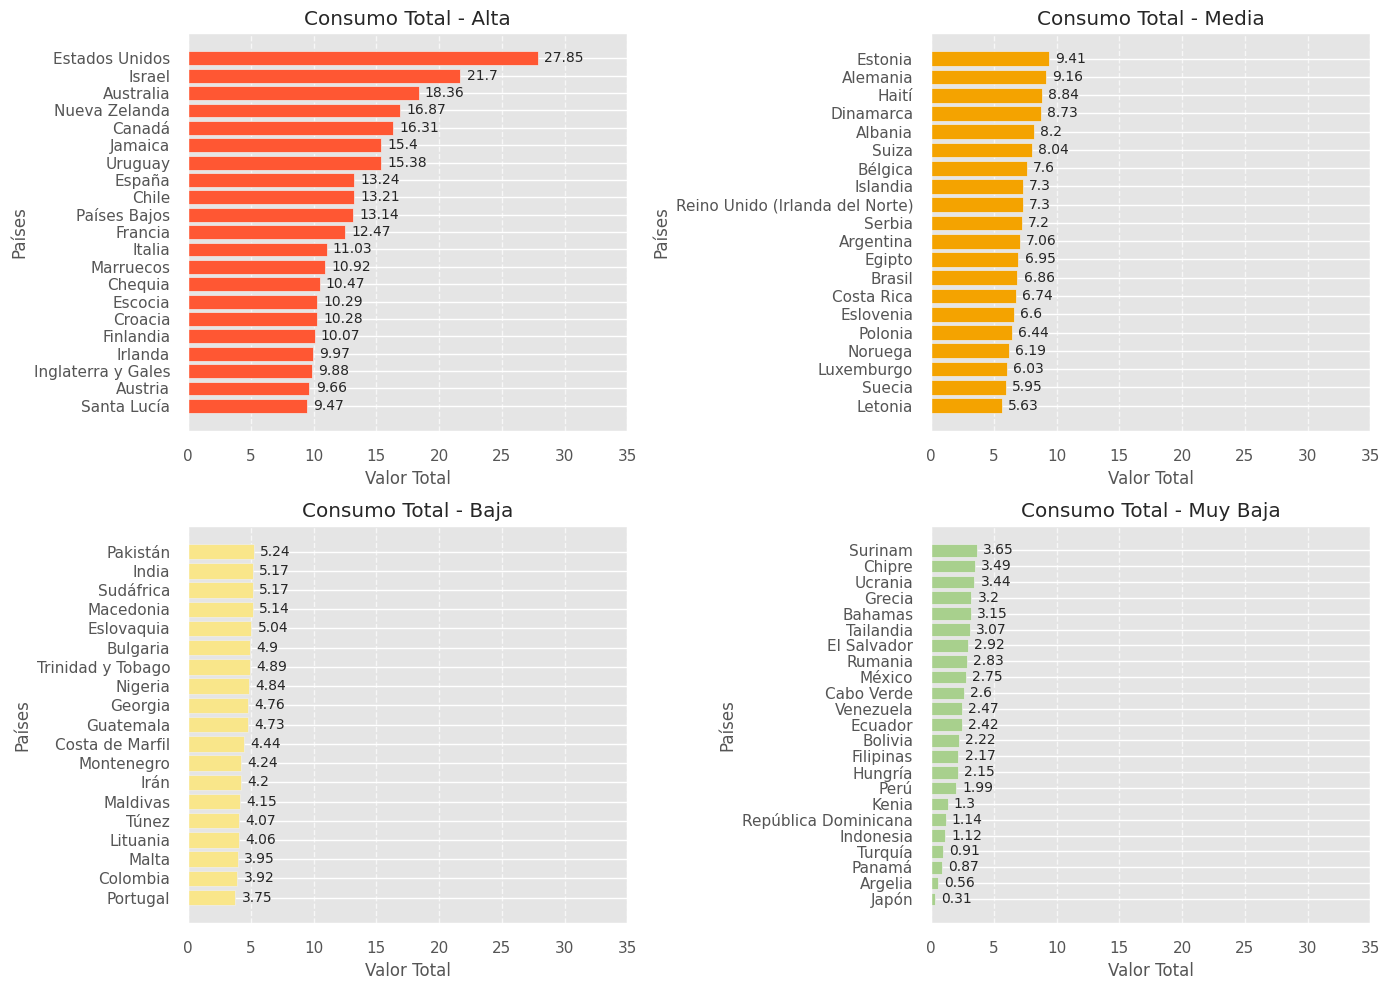

In [152]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

palette = {'Muy Baja': '#A8D08D', 'Baja': '#F9E68A', 'Media': '#F4A300', 'Alta': '#FF5733'}

categorias = ['Alta', 'Media', 'Baja', 'Muy Baja']

for i, categoria in enumerate(categorias):
    ax = axes[i//2, i%2]
    df_categoria = df_consumo[df_consumo['Categoría_Total'] == categoria].sort_values(by='Total', ascending=True)
    ax.barh(df_categoria['País'], df_categoria['Total'], color=palette[categoria])
    ax.set_title(f'Consumo Total - {categoria}')
    ax.set_xlabel('Valor Total')
    ax.set_ylabel('Países')
    ax.set_xlim(0, 35)

    for index, value in enumerate(df_categoria['Total']):
        ax.text(value + 0.5, index, str(round(value, 2)), va='center')

    ax.grid(True, axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [153]:
df_consumo[['País', 'Cocaína']].sort_values(by='Cocaína', ascending=False).head()

,País,Cocaína
4,Australia,2.73
0,Albania,2.50
24,Escocia,2.41
40,Inglaterra y Gales,2.36
28,Estados Unidos,2.31


In [154]:
df_consumo[['País', 'Cannabis']].sort_values(by='Cannabis', ascending=False).head()

,País,Cannabis
44,Israel,20.50
28,Estados Unidos,18.09
12,Canadá,14.10
60,Nueva Zelanda,13.83
46,Jamaica,12.61


In [155]:
df_consumo[['País', 'Metanfetaminas']].sort_values(by='Metanfetaminas', ascending=False).head()

,País,Metanfetaminas
36,Haití,6.10
28,Estados Unidos,2.42
4,Australia,1.73
76,Tailandia,1.67
63,Países Bajos,1.64


In [156]:
df_consumo[['País', 'Opioides']].sort_values(by='Opioides', ascending=False).head()

,País,Opioides
71,Serbia,5.15
28,Estados Unidos,5.03
58,Nigeria,4.66
4,Australia,3.10
42,Irán,3.02


# Trafico

In [157]:
df_trafico = pd.read_csv('trafico.csv')

In [158]:
df_trafico

,País,Cocaína,Cannabis,Metanfetaminas,Heroína
0,Sri Lanka,177609.980000,1731.53,4567.113736,145917.640000
1,Australia,159530.390000,NaN,85635.359116,142964.640000
2,Finlandia,94686.555524,5751.15,14874.141876,53374.333333
3,Palestina,75000.000000,4464.29,NaN,NaN
4,Moldavia,71174.380000,NaN,NaN,126448.890000
...,...,...,...,...,...
85,Catar,NaN,NaN,136314.067612,136314.070000
86,Bangladés,NaN,172.40,NaN,164051.000000
87,Azerbaiyán,NaN,3938.46,6000.000000,17688.680000
88,Arabia Saudita,NaN,6620.37,NaN,NaN


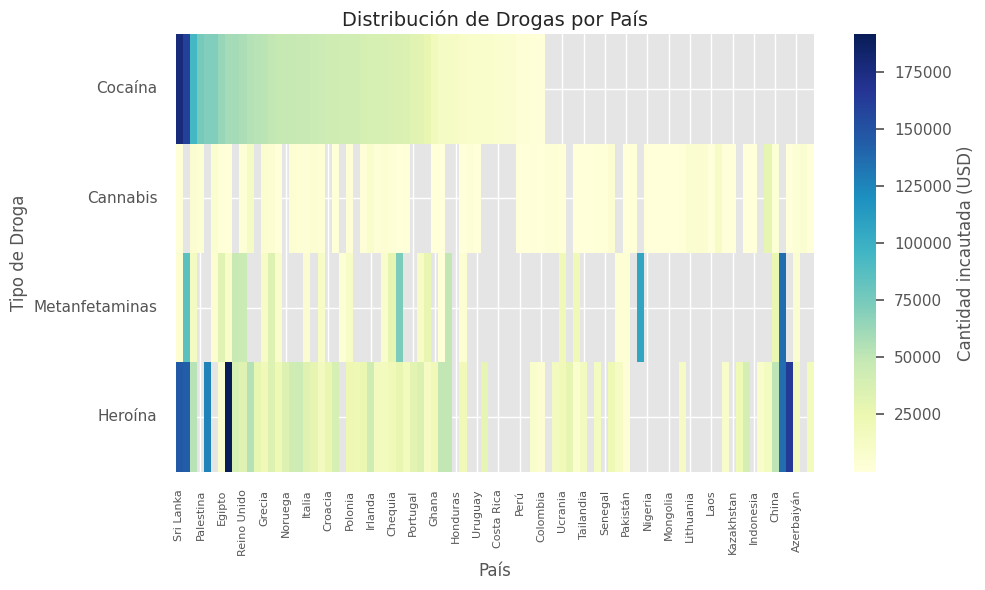

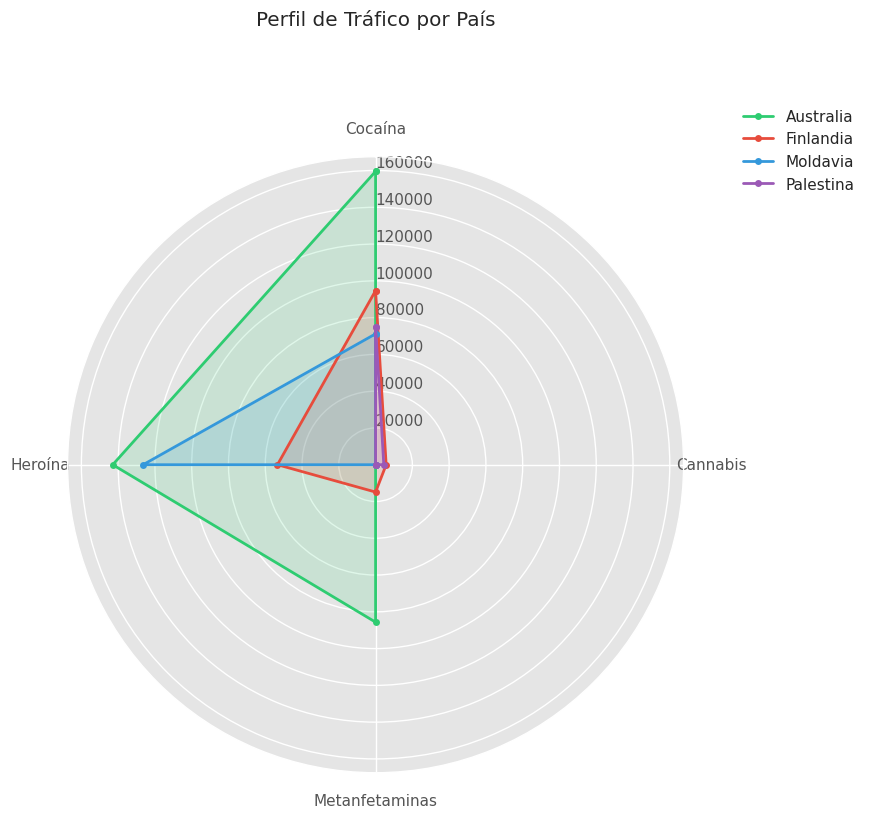

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configuración estética
plt.style.use('ggplot')
colors = ['#2ecc71', '#e74c3c', '#3498db', '#9b59b6']
sns.set_palette(sns.color_palette(colors))

# 1. Heatmap de distribución por drogas
plt.figure(figsize=(10, 6))
heatmap_data = df_trafico.set_index('País').dropna(how='all')
sns.heatmap(heatmap_data.T,
           cmap='YlGnBu',
           mask=heatmap_data.T.isnull(),
           cbar_kws={'label': 'Cantidad incautada (USD)'})
plt.title('Distribución de Drogas por País', fontsize=14)
plt.xlabel('País')
plt.ylabel('Tipo de Droga')
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 2. Radar chart para comparación multidroga
from math import pi

def plot_radar_chart(countries):
    categories = df_trafico.columns[1:]
    N = len(categories)

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, polar=True)

    for idx, country in enumerate(countries):
        values = df_trafico[df_trafico['País'] == country].iloc[:,1:].fillna(0).values[0]
        values = np.append(values, values[:1])

        angles = [n/float(N)*2*pi for n in range(N)]
        angles += angles[:1]

        ax.plot(angles, values, linewidth=2, linestyle='solid',
               label=country, marker='o', markersize=5)
        ax.fill(angles, values, alpha=0.15)

    ax.set_theta_offset(pi/2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], categories)
    ax.set_rlabel_position(0)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.title('Perfil de Tráfico por País', y=1.2)
    plt.show()

plot_radar_chart(['Australia', 'Finlandia', 'Moldavia', 'Palestina'])



# Mercado

In [160]:
df_mercado = pd.read_csv('mercado.csv')

In [161]:
df_mercado.sort_values(by='Consumo_Tn', ascending=False).head(20)

,País,Población,Consumo_Tn,Mercado_USD
0,Estados Unidos,7409071,614.952893,1.875606e+10
1,Brasil,4488953,372.583099,9.314577e+08
2,India,1300000,107.900000,6.438035e+09
3,España,1056208,87.665264,3.748080e+09
4,Alemania,831375,69.004125,3.039619e+09
5,Francia,795088,65.992304,2.544187e+09
6,México,784635,65.124705,6.643807e+08
7,Australia,668847,55.514301,8.856218e+09
8,Italia,656593,54.497219,2.396256e+09
9,Argentina,506004,41.998332,2.099917e+08


# DataFrame

In [162]:
df = pd.read_csv("df.csv")
df

,País,Coca_cultivo,Opio_cultivo,Cocaína_produccion,Categoría_Cocaína_produccion,Opioides_produccion,Categoría_Opioides_produccion,Metanfetaminas_produccion,Categoría_Metanfetaminas_produccion,Cocaína_consumo,...,Categoría_Metanfetaminas_consumo,Opioides_consumo,Categoría_Opioides_consumo,Cocaína_trafico,Cannabis_trafico,Metanfetaminas_trafico,Heroína_trafico,Población,Consumo_Tn,Mercado_USD
0,Afghanistan,NaN,187414.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.50,...,Muy Baja,NaN,NaN,NaN,881.54,NaN,17793.59,NaN,NaN,NaN
2,Germany,NaN,NaN,1.0,MUY BAJA,1.0,MUY BAJA,38.0,ALTA,1.03,...,Alta,0.36,Baja,49544.45106,4653.34,34897.025172,34516.02,831375.0,69.004125,3.039619e+09
3,Saudi Arabia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,6620.37,NaN,NaN,NaN,NaN,NaN
4,Algeria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,...,Muy Baja,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,Ukraine,NaN,NaN,NaN,NaN,NaN,NaN,14.0,MEDIA,0.42,...,Media,NaN,NaN,NaN,2000.00,20089.122653,20089.12,NaN,NaN,NaN
128,Uruguay,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.00,...,Muy Baja,2.54,Alta,8000.00000,516.67,NaN,NaN,68880.0,5.717040,4.573632e+07
129,Uzbekistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3587.50,NaN,16000.00,NaN,NaN,NaN
130,Venezuela,NaN,NaN,271.0,ALTA,NaN,NaN,NaN,NaN,0.73,...,Baja,NaN,NaN,5500.00000,NaN,NaN,NaN,217914.0,18.086862,3.776537e+07


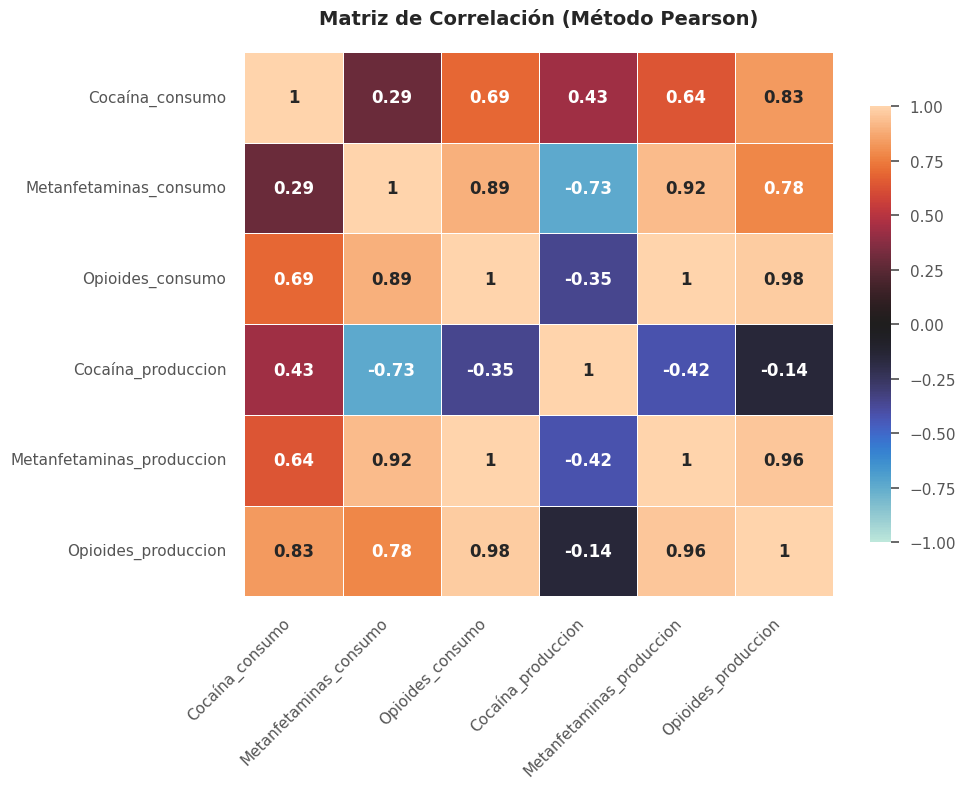

In [163]:
df_corr = df[['Cocaína_consumo','Metanfetaminas_consumo', 'Opioides_consumo', 'Cocaína_produccion',
                      'Metanfetaminas_produccion', 'Opioides_produccion']]\
            .dropna()\
            .apply(pd.to_numeric, errors='coerce')\
            .corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(df_corr,
           annot=True,
           cmap='icefire',
           vmin=-1, vmax=1,
           annot_kws={"size":12, "weight":"bold"},
           linewidths=0.5,
           cbar_kws={"shrink":0.8})

plt.title("Matriz de Correlación (Método Pearson)",
          fontsize=14, pad=20, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [164]:
# IMPORTANTE! : En los gráficos con planisferio, los siguientes paises no se encuentran en la libreria utilizada

# Santa Lucia es importante por d

NAME = set(world.NAME)
Pais = set(df.País)

diferencias = Pais - NAME

print("Países en df.País que no están en world.NAME:")
print(diferencias)

Países en df.País que no están en world.NAME:
{'Maldives', 'Scotland', 'Cape Verde', 'Malta', 'Saint Lucia'}


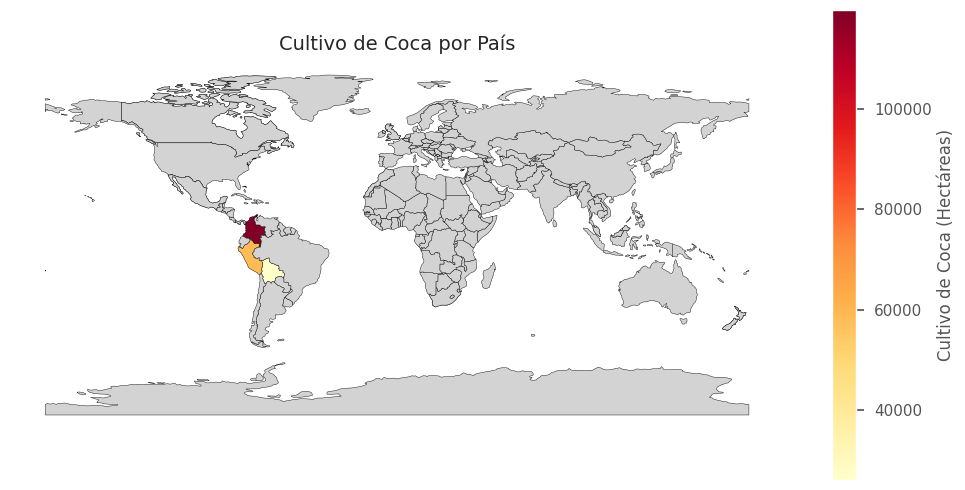

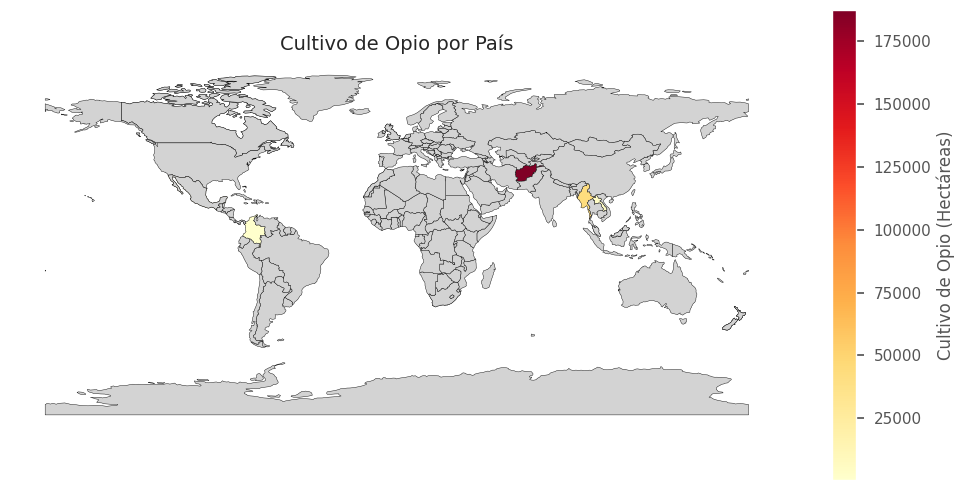

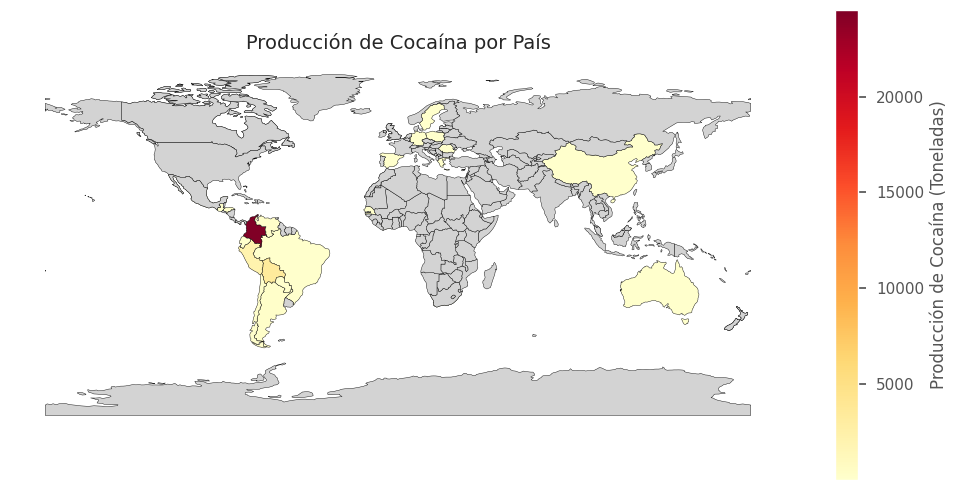

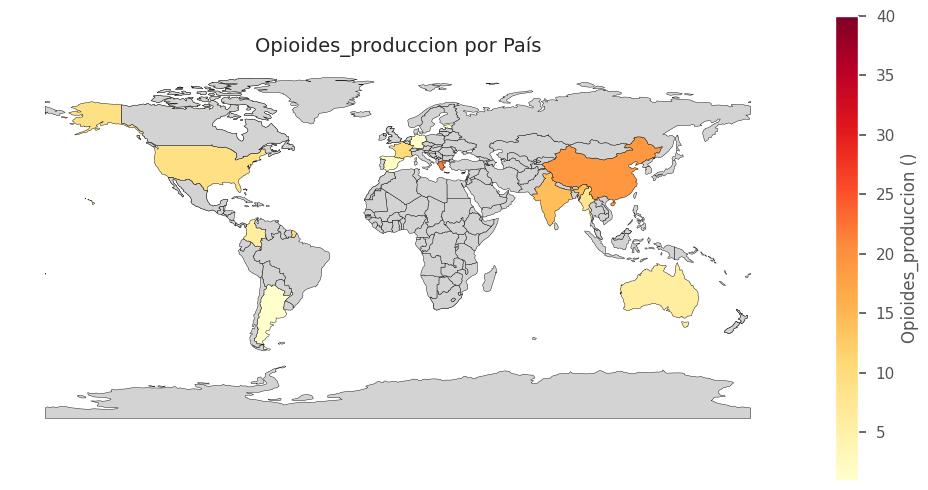

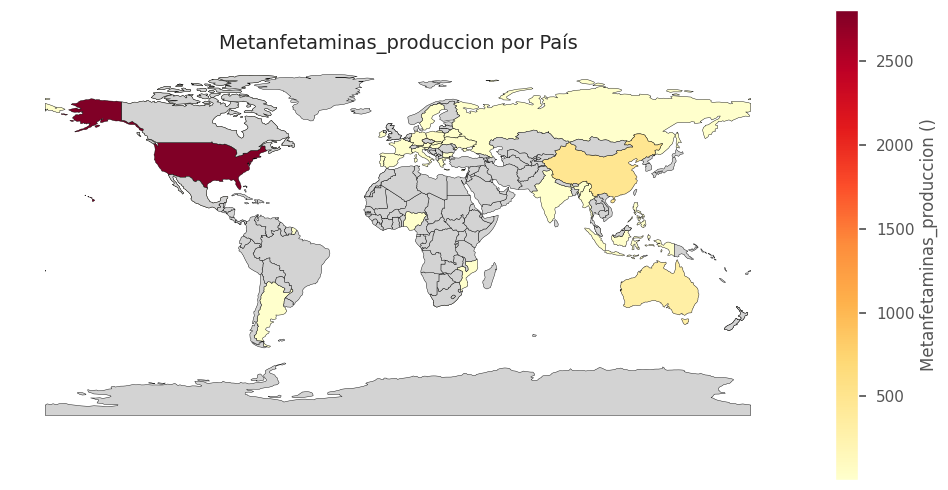

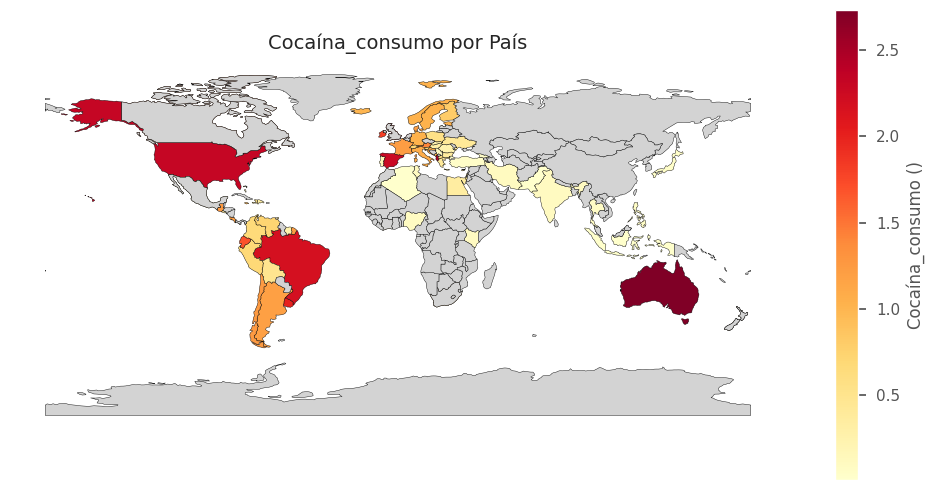

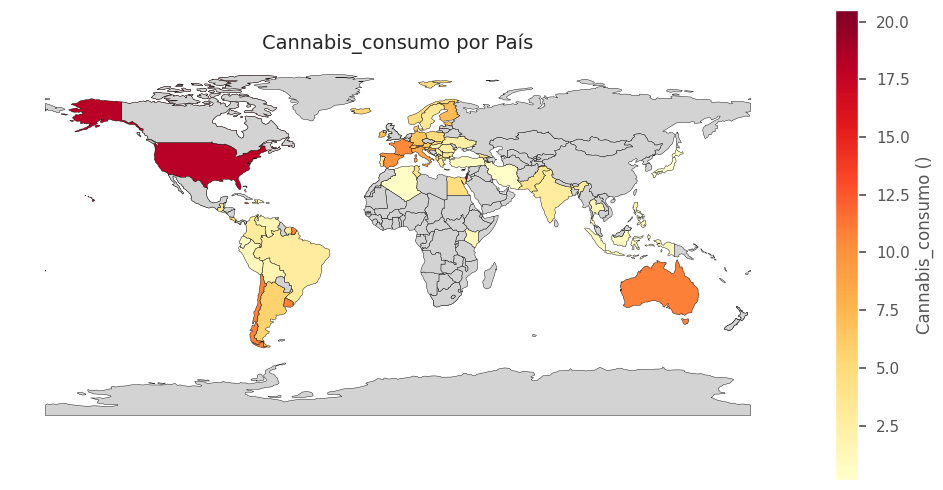

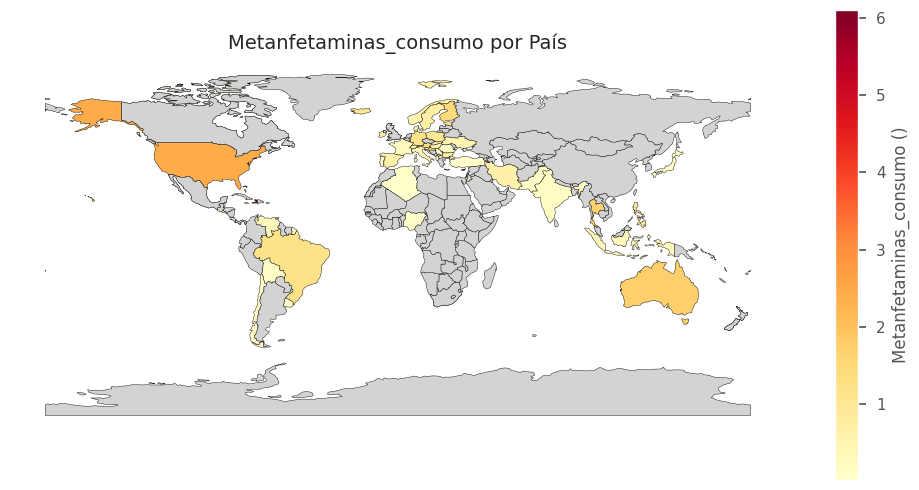

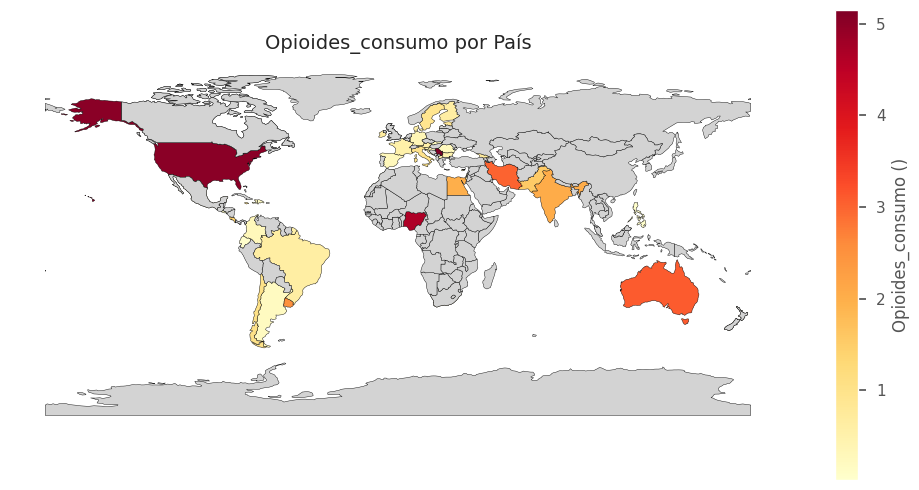

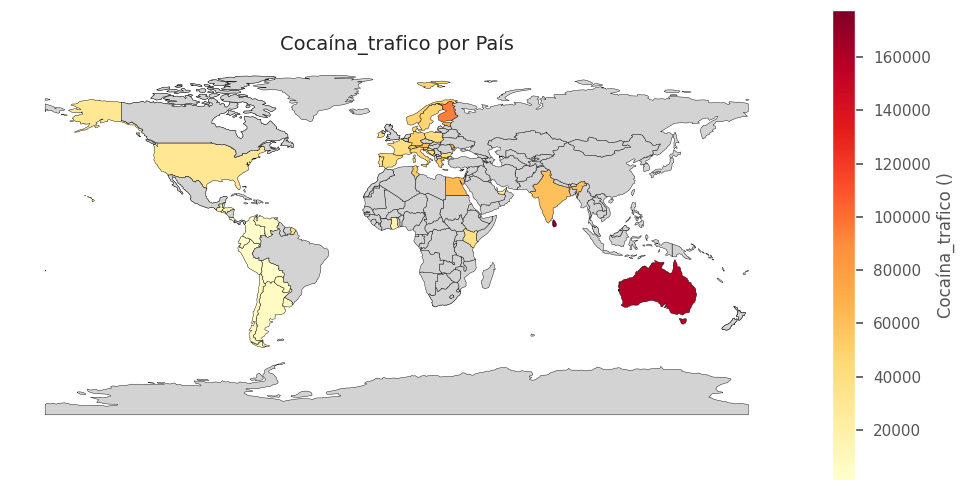

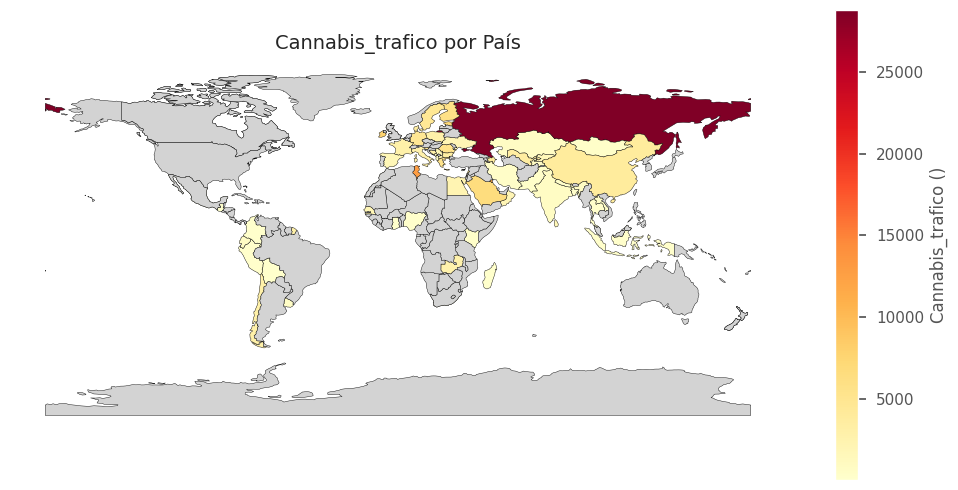

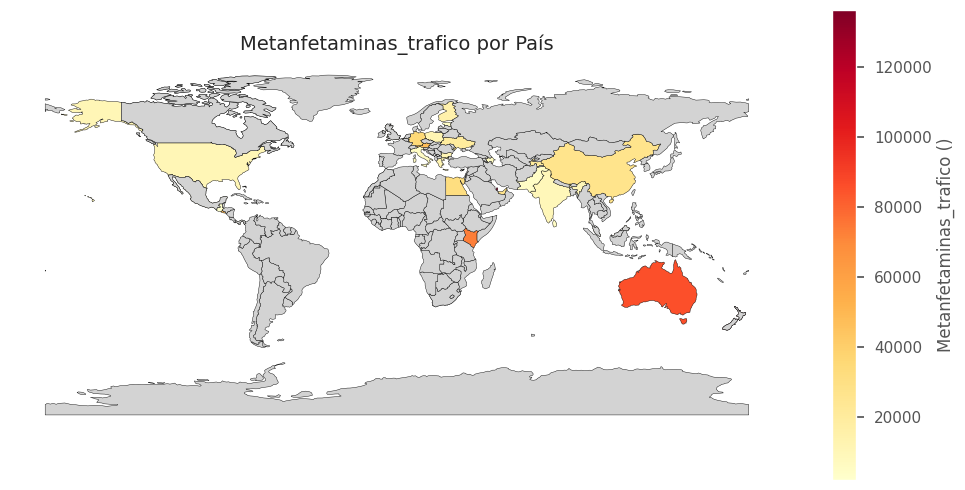

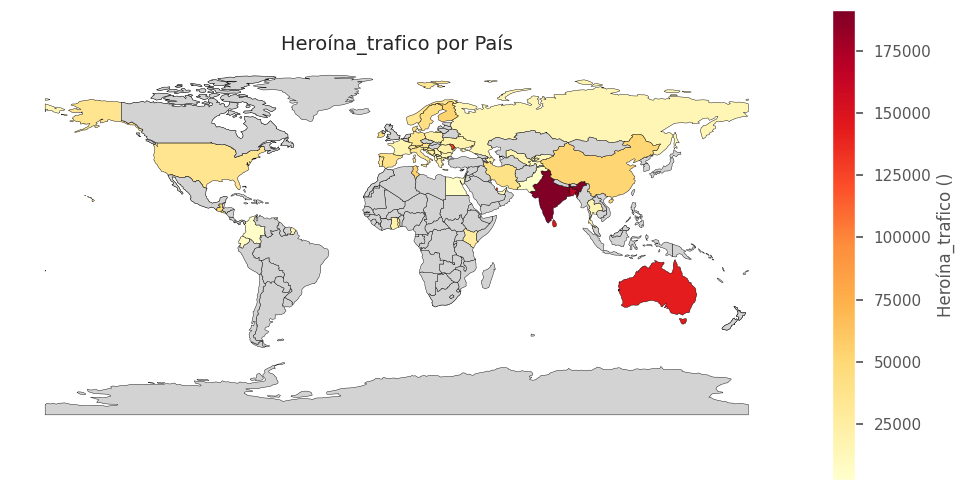

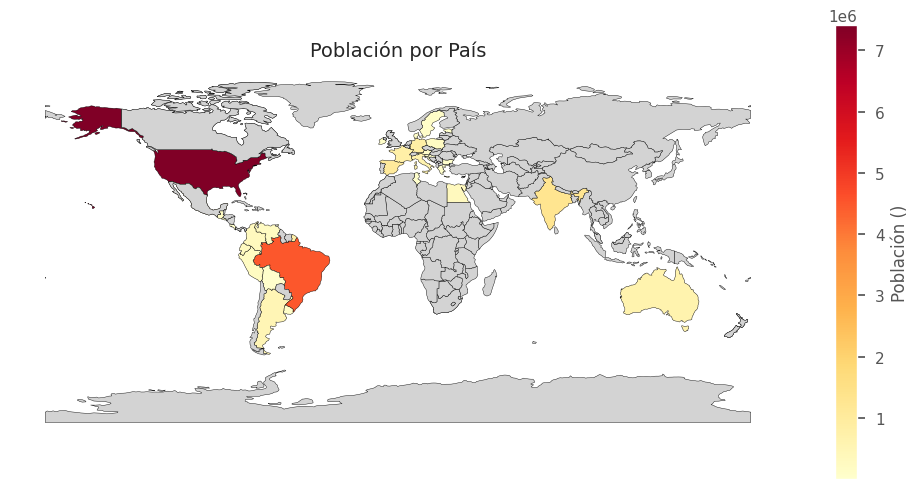

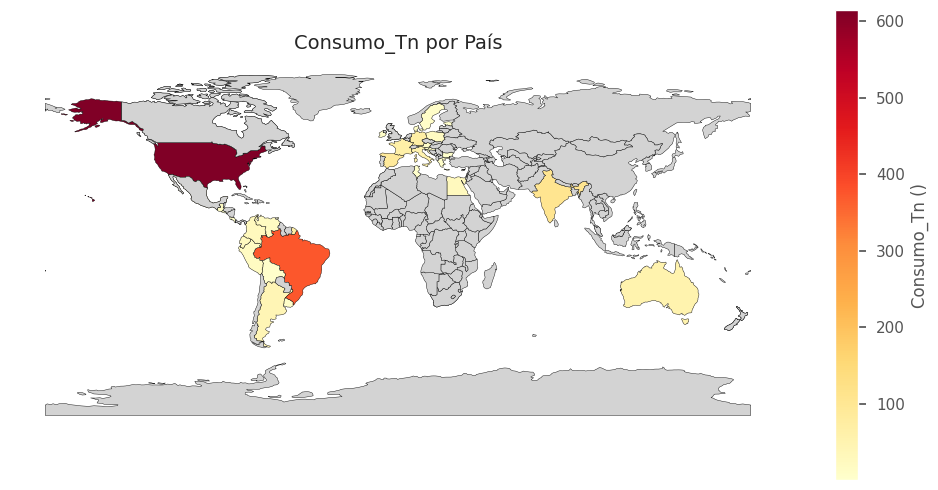

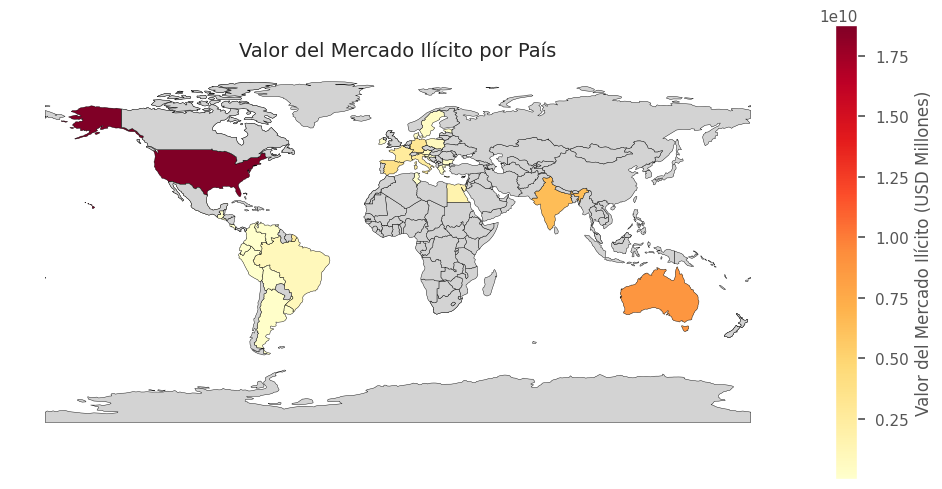

In [165]:
def plot_all_geo_analysis(df):

    columnas_numericas = [
        'Coca_cultivo', 'Opio_cultivo', 'Cocaína_produccion',
        'Opioides_produccion', 'Metanfetaminas_produccion',
        'Cocaína_consumo', 'Cannabis_consumo', 'Metanfetaminas_consumo',
        'Opioides_consumo', 'Cocaína_trafico',
        'Cannabis_trafico', 'Metanfetaminas_trafico', 'Heroína_trafico',
        'Población', 'Consumo_Tn', 'Mercado_USD',
    ]

    config_mapas = {
        'Coca_cultivo': {'titulo': 'Cultivo de Coca', 'unidad': 'Hectáreas'},
        'Opio_cultivo': {'titulo': 'Cultivo de Opio', 'unidad': 'Hectáreas'},
        'Cocaína_produccion': {'titulo': 'Producción de Cocaína', 'unidad': 'Toneladas'},
        'Mercado_USD': {'titulo': 'Valor del Mercado Ilícito', 'unidad': 'USD Millones'}
    }

    for columna in columnas_numericas:

        config = config_mapas.get(columna, {'titulo': columna, 'unidad': ''})

        merged = world.merge(
            df[['País', columna]],
            left_on='NAME',
            right_on='País',
            how='left'
        )

        fig, ax = plt.subplots(figsize=(10, 5))
        merged.plot(
            column=columna,
            ax=ax,
            legend=True,
            legend_kwds={'label': f"{config['titulo']} ({config['unidad']})"},
            missing_kwds={'color': 'lightgrey'},
            edgecolor='black',
            linewidth=0.3,
            cmap='YlOrRd'
        )

        plt.title(f"{config['titulo']} por País", fontsize=14)
        ax.set_axis_off()
        plt.tight_layout()
        plt.show()

plot_all_geo_analysis(df)

# Grafos

In [166]:
G = nx.DiGraph()

for pais, coords in coordenadas_paises.items():
    G.add_node(pais, pos=coords)

for ruta in rutas_trafico:
    G.add_edge(ruta[0], ruta[1], weight=ruta[2])


In [167]:
plt.style.use('seaborn-v0_8')
cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=0, vmax=8000)

G = nx.DiGraph()
for pais, coords in coordenadas_paises.items():
    G.add_node(pais, pos=coords)
for ruta in rutas_trafico:
    G.add_edge(ruta[0], ruta[1], weight=ruta[2])

def get_edge_properties(weight):
    return mcolors.to_hex(cmap(norm(weight)))

fig = go.Figure()

node_connections = {pais: [] for pais in coordenadas_paises}

for u, v, data in G.edges(data=True):
    node_connections[u].append(f"→ {v} ({data['weight']}%)")
    node_connections[v].append(f"← {u} ({data['weight']}%)")

for node, coords in coordenadas_paises.items():
    connections = "<br>".join(node_connections[node])
    fig.add_trace(go.Scattergeo(
        lon=[coords[0]], lat=[coords[1]], text=node,
        mode='markers+text',
        marker=dict(size=10, color='#2c3e50', opacity=0.7, line=dict(width=0.5, color='white')),
        textfont=dict(color='#2c3e50', size=10, family='Arial'),
        textposition='top center',
        hoverinfo="text",
        hovertext=f"<b>{node}</b><br><br>Conexiones:<br>{connections}",
        name='',
        showlegend=False
    ))


legend_groups = {
    'Rutas Principales': ['Colombia', 'Costa Rica', 'Guatemala', 'México', 'Estados Unidos', 'Brasil'],
    'Rutas Europeas': ['España', 'Portugal', 'Francia', 'Alemania', 'Países Bajos', 'Bélgica'],
    'Rutas Secundarias': ['Perú', 'Chile', 'Bolivia', 'Argentina', 'Paraguay', 'Uruguay'],
    'Rutas Transatlanticas': ['Ecuador',  'Venezuela']
}

edge_categories = {
    'Rutas Principales': ['Colombia', 'Costa Rica', 'Guatemala', 'México', 'Estados Unidos', 'Brasil'],
    'Rutas Europeas': ['España', 'Portugal', 'Francia', 'Alemania', 'Países Bajos', 'Bélgica'],
    'Rutas Secundarias': ['Perú', 'Chile', 'Bolivia', 'Argentina','Paraguay', 'Uruguay'],
    'Rutas Transatlanticas': ['Ecuador', 'Venezuela']
}

for u, v, data in G.edges(data=True):
    x0, y0 = G.nodes[u]['pos']
    x1, y1 = G.nodes[v]['pos']
    color = get_edge_properties(data['weight'])
    dx = x1 - x0
    dy = y1 - y0

    line_trace = go.Scattergeo(lon=[x0, x1], lat=[y0, y1], mode='lines',
        line=dict(width=1.5, color=color), opacity=0.8, hoverinfo="text",
        hovertext=f"{u} → {v}<br>Δ Precio: {data['weight']}%", showlegend=False)

    group = next((g for g, c in edge_categories.items() if u in c), None)
    if group:
        line_trace.update(legendgroup=group, visible='legendonly')

    fig.add_trace(line_trace)

for group in legend_groups:
    fig.add_trace(go.Scattergeo(lon=[None], lat=[None], mode='lines',
        line=dict(width=2.5, color='grey'), name=group, legendgroup=group))

fig.add_trace(go.Scattergeo(lon=[None], lat=[None], marker=dict(
    colorscale=[[i/255, mcolors.to_hex(cmap(i/255))] for i in range(256)],
    cmin=0, cmax=8000, colorbar=dict(title=dict(text="<b>Incremento (%)</b>",
    font=dict(size=12)), thickness=20, len=0.6, yanchor='middle', y=0.5, x=0.85,
    tickvals=np.linspace(0, 8000, 5), ticktext=["0%", "2k%", "4k%", "6k%", "8k%"])),
    showlegend=False))

fig.update_layout(
    title=dict(text="<b>Red de Tráfico Global</b><br><sup>Flujos y Revalorización - Cocaína</sup>",
    x=0.05, font=dict(size=22, color='#2c3e50')),
    geo=dict(projection_type='natural earth', showland=True, landcolor='rgb(243, 243, 243)',
    countrycolor='rgb(200, 200, 200)', coastlinecolor='rgb(150, 150, 150)', showcountries=True),
    legend=dict(title='Categorías:', yanchor="top", y=0.97, xanchor="left", x=0.02,
    bgcolor='rgba(255,255,255,0.9)', bordercolor='#CCCCCC', borderwidth=1, font=dict(size=10)),
    margin=dict(l=0, r=0, t=90, b=0), height=750, width=1300, template='plotly_white')

fig.show()

# === INSTRUCCIONES PARA EXPORTAR EL GRÁFICO ===

1. Exportar como HTML interactivo (Recomendado):
```
fig.write_html("red_trafico.html")
```
2. Generar versión estática de respaldo:
```
fig.write_image("red_trafico.png", width=1400, height=800, scale=2)  # PNG HD
fig.write_image("red_trafico.pdf")  # Vectorizado para impresión
```

3. Integrar en PowerPoint/Google Slides:
   a) Insertar PNG/PDF en la slide
   b) Hipervincular la imagen al archivo HTML:
      - PowerPoint: Click derecho > Hipervínculo > Archivo local
      - Google Slides: Usar complemento "Link Tool"

4. Opciones en la nube (online):
   a) Plotly Chart Studio (gratis):

```
import chart_studio
chart_studio.tools.set_credentials_file(username='TU_USER', api_key='TU_KEY')
py.plot(fig, filename="Red_Trafico", auto_open=True)
```
   
   b) GitHub Pages (necesita cuenta GitHub):
      - Subir el HTML a tu repositorio
      - Activar GitHub Pages en settings
      - Usar enlace: https://TU_USER.github.io/REPO/red_trafico.html

5. Consejos de presentación:
   - Pantalla completa: F11 (navegadores)
   - Zoom dinámico: Click + arrastrar
   - Reset vista: Doble click en mapa
   - Prueba TODOS los controles previamente
   - Llevar versión HTML + PNG en USB
   - Plan B: Grabar video pantalla con interacciones

# Ejecutar estas celdas ANTES de la presentación
# y verificar que los archivos se generen correctamente


# === ARCHIVOS GENERADOS ===

red_trafico.html       -> Versión interactiva completa
red_trafico.png        -> Imagen HD estática
red_trafico.pdf        -> Vectorizado para documentos
